Group Project

In [36]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [77]:
import os
from dotenv import load_dotenv
import mysql.connector 
from mysql.connector import Error
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [56]:
# Load environment variables from .env file
load_dotenv()

True

In [57]:
TICKETMASTER_API_KEY = os.getenv('TICKETMASTER_API_KEY')
TOMORROW_API_KEY = os.getenv('TOMORROW_API_KEY')   

TICKETMASTER_Events_API_Endpoint = "https://app.ticketmaster.com/discovery/v2/events.json"
TOMORROW_API_Endpoint = "https://api.tomorrow.io/v4/weather/forecast"


In [58]:
MYSQL_HOST = os.getenv('MYSQL_HOST')
MYSQL_USER = os.getenv('MYSQL_USER')
MYSQL_PASSWORD = os.getenv('MYSQL_PASSWORD')
MYSQL_DATABASE = os.getenv('MYSQL_DATABASE')

conn = mysql.connector.connect(
    host=MYSQL_HOST,
    user=MYSQL_USER,
    password=MYSQL_PASSWORD,
    database=MYSQL_DATABASE
)

In [59]:
# In order to pull the next 7 days of events
# Get today's date
today = datetime.today()

# Get the date 6 days from today
six_days_later = today + timedelta(days=6)

# Format the dates in the correct format (e.g., 'YYYY-MM-DD')
start_date = today.strftime('%Y-%m-%dT00:00:00Z')
end_date = six_days_later.strftime('%Y-%m-%dT23:59:59Z')

In [60]:
# EVENTS API
# API pull with parameters
params = {
    "apikey": TICKETMASTER_API_KEY,       
    "city": "San Diego", 
    "size": 200,
    "startDateTime": start_date,  # Start date (today)
    "endDateTime": end_date      # End date (7 days later)                 
}

# Send the request to the API
response = requests.get(TICKETMASTER_Events_API_Endpoint, params=params)

In [61]:
#Establish connection
cursor = conn.cursor()

if conn.is_connected():
    print("Connection is active")
else:
    print("Connection is not active")

Connection is active


In [62]:
# Check API response is successful
if response.status_code == 200:
    print("API call successful!")  
    
    # Process the response data
    data = response.json()
    events = data.get("_embedded", {}).get("events", [])

    # Convert data to a DataFrame
    df = pd.DataFrame(events)

API call successful!


In [104]:
# Review the first 10 rows of the DataFrame before further processing
#limit column width for table
pd.set_option('display.max_colwidth', 40)  

# View the rows
df.head(5)

,name,type,id,test,url,locale,images,sales,dates,classifications,...,event_name,event_start_date,event_category,venue_id,venue_name,venue_city,venue_state,venue_zip,venue_country,venue_location
0,"Gavin Adcock - Actin' Up Again, Agai...",event,vvG1iZb8DQ_-zx,False,https://concerts.livenation.com/gavi...,en-us,"[{'ratio': '16_9', 'url': 'https://s...",{'public': {'startDateTime': '2024-0...,{'start': {'localDate': '2025-02-15'...,"[{'primary': True, 'segment': {'id':...",...,"Gavin Adcock - Actin' Up Again, Agai...",2025-02-15,Music,KovZ917AxAB,The Observatory North Park,San Diego,CA,92104,US,"32.748097,-117.131213"
1,Harlem Globetrotters,event,Z7r9jZ1A78-7k,False,https://www.ticketmaster.com/event/Z...,en-us,"[{'ratio': '16_9', 'url': 'https://s...",{'public': {'startDateTime': '2024-0...,{'start': {'localDate': '2025-02-15'...,"[{'primary': True, 'segment': {'id':...",...,Harlem Globetrotters,2025-02-15,Sports,ZFr9jZ7ae7,Pechanga Arena San Diego,San Diego,CA,92110,US,"32.777599000,-117.195999000"
2,UC San Diego Tritons Mens Basketball...,event,Z7r9jZ1A78woa,False,https://www.ticketmaster.com/event/Z...,en-us,"[{'ratio': '16_9', 'url': 'https://s...",{'public': {'startDateTime': '1900-0...,{'start': {'localDate': '2025-02-15'...,"[{'primary': True, 'segment': {'id':...",...,UC San Diego Tritons Mens Basketball...,2025-02-15,Sports,Z7r9jZaAZP,LionTree Arena,San Diego,CA,92093,US,"32.833900000,-117.257500000"
3,Video Age - (21+),event,Z7r9jZ1A7f6qs,False,https://www.ticketmaster.com/event/Z...,en-us,"[{'ratio': '16_9', 'url': 'https://s...",{'public': {'startDateTime': '1900-0...,{'start': {'localDate': '2025-02-14'...,"[{'primary': True, 'segment': {'id':...",...,Video Age - (21+),2025-02-14,Music,Z6r9jZd1ee,Casbah-San Diego,San Diego,CA,92101,US,"32.725300000,-117.172096000"
4,The Adolescents w/ Greg Antista and ...,event,Z7r9jZ1A7faP9,False,https://www.ticketmaster.com/event/Z...,en-us,"[{'ratio': '16_9', 'url': 'https://s...",{'public': {'startDateTime': '1900-0...,{'start': {'localDate': '2025-02-15'...,"[{'primary': True, 'segment': {'id':...",...,The Adolescents w/ Greg Antista and ...,2025-02-15,Music,Z6r9jZd1ee,Casbah-San Diego,San Diego,CA,92101,US,"32.725300000,-117.172096000"


In [64]:
# Extract Event details
df['event_id'] = df['id']
df['event_name'] = df['name']
df['event_start_date'] = df['dates'].apply(lambda x: x['start']['localDate'] if isinstance(x, dict) and 'start' in x else None)
df['event_category'] = df['classifications'].apply(lambda x: x[0]['segment']['name'] if isinstance(x, list) and len(x) > 0 and 'segment' in x[0] else None
)

In [65]:
# Extract Venue details
df['venue_id'] = df['_embedded'].apply(lambda x: x['venues'][0]['id'] if isinstance(x, dict) and 'venues' in x else None)
df['venue_name'] = df['_embedded'].apply(lambda x: x['venues'][0]['name'] if isinstance(x, dict) and 'venues' in x else None)
df['venue_city'] = df['_embedded'].apply(lambda x: x['venues'][0]['city']['name'] if isinstance(x, dict) and 'venues' in x else None)
df['venue_state'] = df['_embedded'].apply(lambda x: x['venues'][0]['state']['stateCode'] if isinstance(x, dict) and 'venues' in x and 'state' in x['venues'][0] else None)
df['venue_zip'] = df['_embedded'].apply(lambda x: x['venues'][0].get('postalCode') if isinstance(x, dict) and 'venues' in x else None)
df['venue_country'] = df['_embedded'].apply(lambda x: x['venues'][0]['country']['countryCode'] if isinstance(x, dict) and 'venues' in x else None)
df['venue_location'] = df['_embedded'].apply(lambda x: f"{x['venues'][0]['location']['latitude']},{x['venues'][0]['location']['longitude']}" if isinstance(x, dict) and 'venues' in x and 'location' in x['venues'][0] else None
)

In [71]:
# Prepare data for insertion
events_df = df[['event_id', 'event_name', 'event_start_date', 'venue_id', 'event_category']]
venues_df = df[['venue_id', 'venue_name', 'venue_city', 'venue_state', 'venue_country', 'venue_location']].drop_duplicates() #only show each venue once

print(f"Number of rows pulled from API: {len(events_df)}")

Number of rows pulled from API: 73


In [70]:
# Insert data to the database or provide failure status
try:
    cursor = conn.cursor()

    # Before loading in new data, delete event data that is in the past now since the last pull
    delete_past_events_query = "DELETE FROM events WHERE start_date < CURDATE();"
    cursor.execute(delete_past_events_query)
    deleted_events_count = cursor.rowcount  # Get the number of deleted rows
    conn.commit()  # Commit deletion
    print(f"Count of past events deleted from MySQL: {deleted_events_count}")  

    # Insert venues (ignore duplicates)
    insert_venue_query = """
    INSERT INTO venues (venue_id, name, city, state, country, location)
    VALUES (%s, %s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE 
        name=VALUES(name), 
        city=VALUES(city), 
        state=VALUES(state),
        country=VALUES(country),
        location=VALUES(location);
    """

    for _, row in venues_df.iterrows():
        cursor.execute(insert_venue_query, tuple(row))
    conn.commit()  # Commit after inserting venues

    # Insert events (ignore duplicates)
    insert_event_query = """
    INSERT INTO events (event_id, name, start_date, venue_id, category)
    VALUES (%s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE 
        name=VALUES(name),
        start_date=VALUES(start_date),
        venue_id=VALUES(venue_id),
        category=VALUES(category);
    """

    for _, row in events_df.iterrows():
        cursor.execute(insert_event_query, tuple(row))
    conn.commit()  # Commit after inserting events

        
    print(f"Inserted {cursor.rowcount} records into MySQL!")

except Error as e:
    print(f"Error: {e}")

else:
    print(f"API call succeeded with status {response.status_code}")

finally:
    if 'conn' in locals() and conn.is_connected():
        cursor.close()
        print("MySQL connection all set!")

Count of past events deleted from MySQL: 3
Inserted 0 records into MySQL!
API call succeeded with status 200
MySQL connection all set!


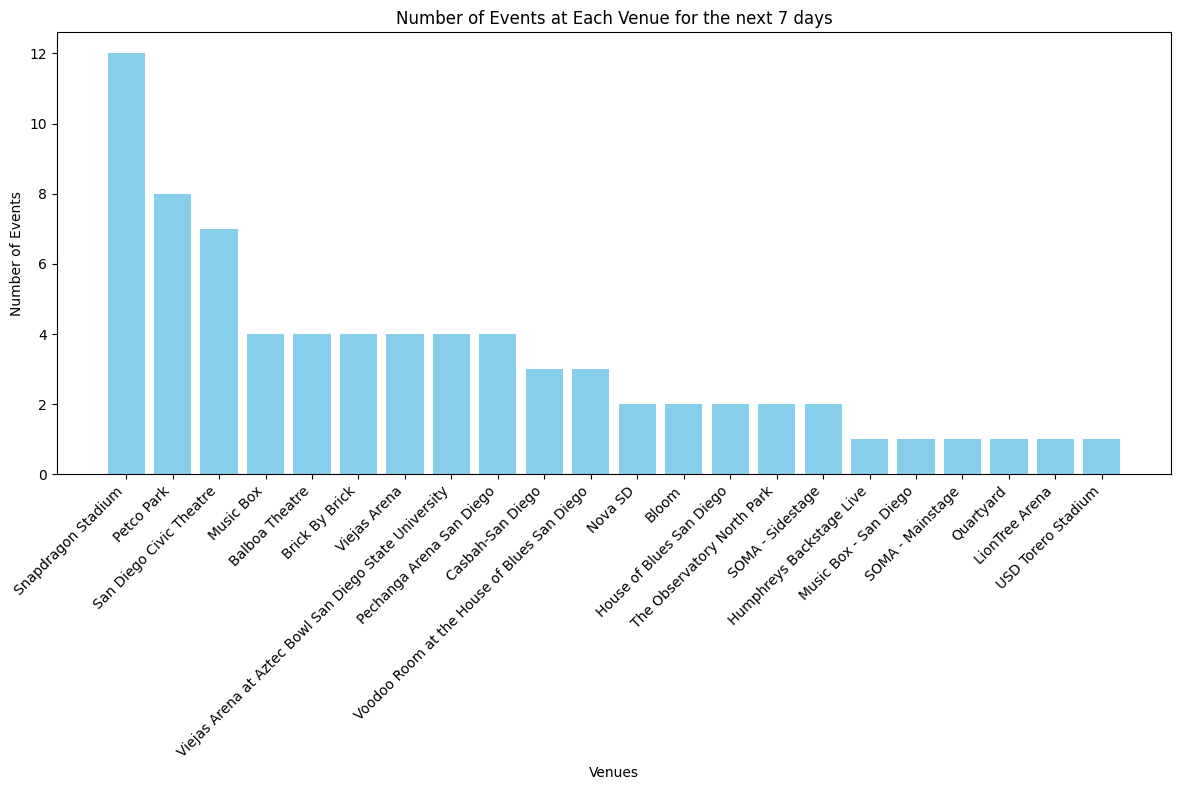

In [101]:
# Group by 'venue_name' and 'event_id' to ensure distinct events are counted
event_counts = df.groupby('venue_name')['event_id'].nunique().reset_index()

# Rename columns for better readability
event_counts.columns = ['Venue', 'Number of Events']

# Sort the DataFrame in descending order by the number of events
event_counts = event_counts.sort_values(by='Number of Events', ascending=False)

# Create a bar plot to visualize the number of events at each venue
plt.figure(figsize=(12, 8))
plt.bar(event_counts['Venue'], event_counts['Number of Events'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Number of Events at Each Venue for the next 7 days')
plt.xlabel('Venues')
plt.ylabel('Number of Events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [92]:
# Count the number of missing values in the 'venue_name' column
missing_venue_name_count = df['venue_name'].isna().sum()

# Print the count of missing data
print(f"Number of missing 'venue_name' values: {missing_venue_name_count}")

Number of missing 'venue_name' values: 0


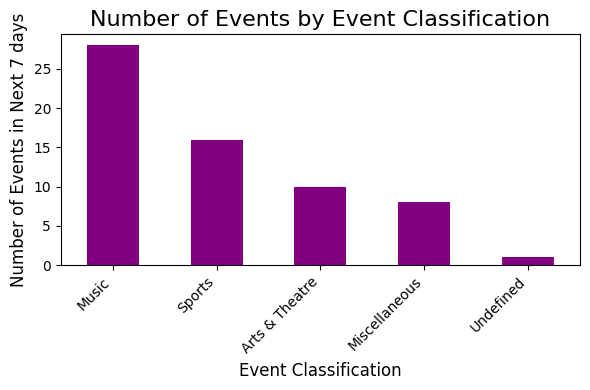

In [91]:
# Group the events by classification and count the number of events in each category
classification_event_count = events_df['event_category'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
classification_event_count.plot(kind='bar', color='purple')

# Set titles and labels
plt.title('Number of Events by Event Classification', fontsize=16)
plt.xlabel('Event Classification', fontsize=12)
plt.ylabel('Number of Events in Next 7 days', fontsize=12)
plt.xticks(rotation=45, ha='right')  

# Display the plot
plt.tight_layout()  
plt.show()